In [1]:
# Compare hardness characterization by removing the "hard" points first
import numpy as np
import pandas as pd

X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

knn_1 = pd.read_csv('../outputs/results/knn_1.csv')['0']
knn_5 = pd.read_csv('../outputs/results/knn_5.csv')['0']
knn_100 = pd.read_csv('../outputs/results/knn_100.csv')['0']
uncertainty = pd.read_csv('../outputs/results/aleatoric.csv')['0']
confidence = pd.read_csv('../outputs/results/confidence.csv')['0']
# forget = pd.read_csv('../outputs/results/forget.csv')['0']
# learnt = pd.read_csv('../outputs/results/learnt.csv')['0']

In [2]:
# KNN - Hardest first
ind_knn_1 = list(knn_1.sort_values(ascending=True).index)
ind_knn_5 = list(knn_5.sort_values(ascending=True).index)
ind_knn_100 = list(knn_100.sort_values(ascending=True).index)

# DataIQ - Divide in Hard/Easy/Ambiguous
uncertainty_thresh = 0.2
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_scores = confidence[(confidence <= conf_thresh_low) & (uncertainty <= uncertainty_thresh)]
easy_scores = confidence[(confidence >= conf_thresh_high) & (uncertainty <= uncertainty_thresh)]
ambig_scores = uncertainty[((confidence > conf_thresh_low) & (confidence < conf_thresh_high)) | (uncertainty > uncertainty_thresh)]

# Now hardest first, then most ambiguous, then easy
ind_hard = pd.Series(hard_scores).sort_values(ascending=True).index 
ind_easy = pd.Series(easy_scores).sort_values(ascending=True).index
ind_ambig = pd.Series(ambig_scores).sort_values(ascending=False).index
ind_dataiq = list(np.concatenate((ind_hard, ind_ambig, ind_easy)))

# Forget - Hardest are the ones forgotten most often
# ind_forget = pd.Series(forget).sort_values(ascending=False).index

In [3]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.utils.train_xgb import remove_hard

knn_1_means, knn_1_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_1, n=5000, k=10)
knn_5_means, knn_5_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_5, n=5000, k=10)
knn_100_means, knn_100_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_100, n=5000, k=10)
dataiq_means, dataiq_stds = remove_hard(X_train, y_train, X_v, y_v, ind_dataiq, n=5000, k=10)
# forget_means, forget_stds = remove_hard(X_train, y_train, X_v, y_v, ind_forget, n=5000, k=10)
ind_rand = np.random.permutation(len(X_train))
rand_means, rand_stds = remove_hard(X_train, y_train, X_v, y_v, ind_rand, n=5000, k=10)


  0%|                                                                                                                                                          | 0/11 [00:00<?, ?it/s]


  9%|████████████▉                                                                                                                                 | 1/11 [58:19<9:43:12, 3499.24s/it]


 18%|█████████████████████████▍                                                                                                                  | 2/11 [1:56:55<8:46:21, 3509.07s/it]


 27%|██████████████████████████████████████▏                                                                                                     | 3/11 [2:52:25<7:36:58, 3427.34s/it]


 36%|██████████████████████████████████████████████████▉                                                                                         | 4/11 [3:51:11<6:44:25, 3466.56s/it]


 45%|███████████████████████████████████████████████████████████████▋                                                                            | 5/11 [4:43:15<5:34:17, 3342.99s/it]


 55%|████████████████████████████████████████████████████████████████████████████▎                                                               | 6/11 [5:21:21<4:08:38, 2983.66s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                   | 7/11 [5:54:43<2:57:30, 2662.62s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8/11 [6:39:08<2:13:09, 2663.24s/it]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 9/11 [7:23:13<1:28:35, 2657.55s/it]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 10/11 [8:06:20<43:55, 2635.93s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [8:46:02<00:00, 2558.09s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [8:46:02<00:00, 2869.31s/it]


  0%|                                                                                                                                                   | 0/11 [00:00<?, ?it/s]


  9%|████████████▎                                                                                                                          | 1/11 [58:39<9:46:30, 3519.09s/it]


 18%|████████████████████████▏                                                                                                            | 2/11 [1:39:37<7:14:17, 2895.31s/it]


 27%|████████████████████████████████████▎                                                                                                | 3/11 [2:37:45<7:02:04, 3165.62s/it]


 36%|████████████████████████████████████████████████▎                                                                                    | 4/11 [3:30:22<6:08:57, 3162.51s/it]


 45%|████████████████████████████████████████████████████████████▍                                                                        | 5/11 [4:17:38<5:04:27, 3044.66s/it]


 55%|████████████████████████████████████████████████████████████████████████▌                                                            | 6/11 [5:00:26<4:00:13, 2882.65s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████▋                                                | 7/11 [5:43:12<3:05:16, 2779.07s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8/11 [6:25:36<2:15:13, 2704.34s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 9/11 [7:02:51<1:25:15, 2557.55s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 10/11 [7:35:40<39:35, 2375.76s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [7:58:29<00:00, 2067.58s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [7:58:29<00:00, 2609.92s/it]


  0%|                                                                                                                                                   | 0/11 [00:00<?, ?it/s]


  9%|████████████                                                                                                                        | 1/11 [1:01:30<10:15:00, 3690.00s/it]


 18%|████████████████████████▏                                                                                                            | 2/11 [2:01:04<9:03:18, 3622.08s/it]


 27%|████████████████████████████████████▎                                                                                                | 3/11 [2:58:41<7:52:54, 3546.78s/it]


 36%|████████████████████████████████████████████████▎                                                                                    | 4/11 [3:46:38<6:22:57, 3282.45s/it]


 45%|████████████████████████████████████████████████████████████▍                                                                        | 5/11 [4:23:51<4:50:24, 2904.03s/it]


 55%|████████████████████████████████████████████████████████████████████████▌                                                            | 6/11 [4:55:51<3:34:07, 2569.45s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████▋                                                | 7/11 [5:25:17<2:33:45, 2306.47s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8/11 [5:48:46<1:41:02, 2020.87s/it]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9/11 [6:04:41<56:15, 1687.83s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 10/11 [6:16:24<23:03, 1383.61s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [6:26:58<00:00, 1154.32s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [6:26:58<00:00, 2110.79s/it]


  0%|                                                                                                                                                   | 0/11 [00:00<?, ?it/s]


  9%|████████████                                                                                                                        | 1/11 [1:00:00<10:00:00, 3600.06s/it]


 18%|████████████████████████▏                                                                                                            | 2/11 [1:43:02<7:30:11, 3001.27s/it]


 27%|████████████████████████████████████▎                                                                                                | 3/11 [2:47:25<7:32:40, 3395.09s/it]


 36%|████████████████████████████████████████████████▎                                                                                    | 4/11 [3:44:27<6:37:17, 3405.37s/it]


 45%|████████████████████████████████████████████████████████████▍                                                                        | 5/11 [4:44:03<5:46:41, 3466.98s/it]


 55%|████████████████████████████████████████████████████████████████████████▌                                                            | 6/11 [5:37:10<4:40:59, 3371.91s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████▋                                                | 7/11 [6:25:41<3:34:45, 3221.30s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8/11 [7:19:03<2:40:44, 3214.93s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 9/11 [7:53:03<1:34:55, 2847.62s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 10/11 [8:26:24<43:06, 2586.48s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [9:00:25<00:00, 2419.29s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [9:00:25<00:00, 2947.73s/it]


  0%|                                                                                                                                                   | 0/11 [00:00<?, ?it/s]


  9%|████████████▎                                                                                                                          | 1/11 [44:34<7:25:46, 2674.66s/it]


 18%|████████████████████████▏                                                                                                            | 2/11 [1:42:38<7:52:34, 3150.53s/it]


 27%|████████████████████████████████████▎                                                                                                | 3/11 [2:39:28<7:15:53, 3269.22s/it]


 36%|████████████████████████████████████████████████▎                                                                                    | 4/11 [3:16:58<5:34:27, 2866.77s/it]


 45%|████████████████████████████████████████████████████████████▍                                                                        | 5/11 [3:55:29<4:26:37, 2666.22s/it]


 55%|████████████████████████████████████████████████████████████████████████▌                                                            | 6/11 [4:45:47<3:52:09, 2785.87s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████▋                                                | 7/11 [5:35:58<3:10:38, 2859.67s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8/11 [6:11:35<2:11:28, 2629.52s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 9/11 [6:58:40<1:29:40, 2690.42s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 10/11 [7:33:43<41:49, 2509.25s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [8:21:01<00:00, 2609.87s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [8:21:01<00:00, 2732.87s/it]

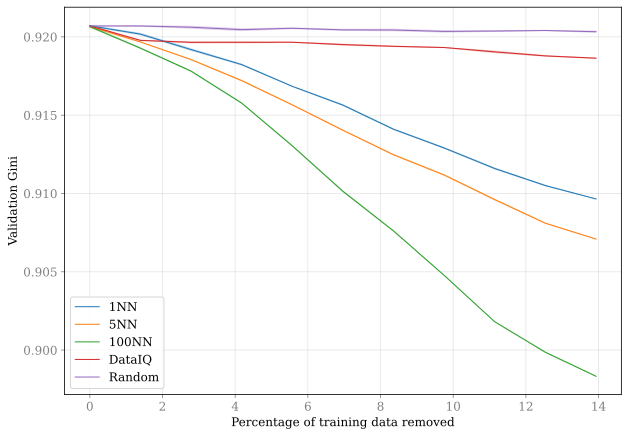

In [4]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
n, k = 5000, 10
ns = [_ * n for _ in range(k + 1)]
frac_removed = [(1 - (len(X_train) - n) / len(X_train)) * 100 for n in ns]
ax.plot(frac_removed, knn_1_means, lw=1, label='1NN')
ax.fill_between(frac_removed, knn_1_means - 1.96 * np.array(knn_1_stds) / np.sqrt(10), knn_1_means + 1.96 * np.array(knn_1_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, knn_5_means, lw=1, label='5NN')
ax.fill_between(frac_removed, knn_5_means - 1.96 * np.array(knn_5_stds) / np.sqrt(10), knn_5_means + 1.96 * np.array(knn_5_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, knn_100_means, lw=1, label='100NN')
ax.fill_between(frac_removed, knn_100_means - 1.96 * np.array(knn_100_stds) / np.sqrt(10), knn_100_means + 1.96 * np.array(knn_100_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, dataiq_means, lw=1, label='DataIQ')
ax.fill_between(frac_removed, dataiq_means - 1.96 * np.array(dataiq_stds) / np.sqrt(10), dataiq_means + 1.96 * np.array(dataiq_stds) / np.sqrt(10), alpha=0.3)
#ax.plot(frac_removed, forget_means, lw=1, label='Forget')
# ax.fill_between(frac_removed, forget_means - 1.96 * np.array(forget_stds) / np.sqrt(10), forget_means + 1.96 * np.array(forget_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, rand_means, lw=1, label='Random')
ax.fill_between(frac_removed, rand_means - 1.96 * np.array(rand_stds) / np.sqrt(10), rand_means + 1.96 * np.array(rand_stds) / np.sqrt(10), alpha=0.3)
ax.set_xlabel('Percentage of training data removed')
ax.set_ylabel('Validation Gini')
ax.legend()
fig.savefig('../outputs/figures/compare_hardness.pdf', dpi=300, bbox_inches='tight')